# Import Packages

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import numpy as np
import random

# (A) : Loading Data

In [2]:
df = pd.read_csv('./Data/HW2_data/international_matches.csv')
df.tail(10)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23911,2022-06-14,Ukraine,Republic of Ireland,Europe,Europe,27,47,1535,1449,1,...,No,Draw,75.0,75.0,74.8,78.7,80.0,76.5,72.7,73.8
23912,2022-06-14,Bosnia and Herzegovina,Finland,Europe,Europe,59,57,1388,1406,3,...,No,Win,76.0,83.0,74.2,77.0,78.0,70.0,72.3,73.5
23913,2022-06-14,Romania,Montenegro,Europe,Europe,48,70,1446,1342,0,...,No,Lose,77.0,65.0,73.5,73.7,75.0,76.2,74.7,68.2
23914,2022-06-14,Luxembourg,Faroe Islands,Europe,Europe,94,124,1229,1137,2,...,No,Draw,69.0,NaN,68.5,NaN,69.8,NaN,NaN,NaN
23915,2022-06-14,Turkey,Lithuania,Europe,Europe,43,138,1461,1092,2,...,No,Win,79.0,71.0,78.2,76.7,78.2,NaN,NaN,NaN
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


# (B) : Plot Scatter Of Data

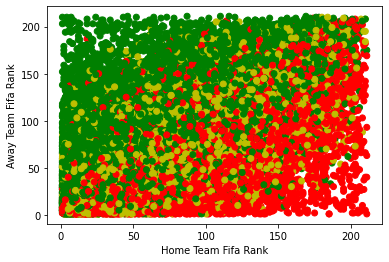

In [3]:
rank_home = df['home_team_fifa_rank']
rank_away = df['away_team_fifa_rank']
home_result = df['home_team_result']

color = []
for i in home_result:
    if(i=='Win'):
        color.append('g')
    elif(i=='Lose'):
        color.append('r')
    else:
        color.append('y')


plt.scatter(rank_home, rank_away, c=color)
plt.xlabel('Home Team Fifa Rank')
plt.ylabel('Away Team Fifa Rank')
plt.show()


# (C) : Create Custom Dataset

In [4]:
train_percent = 0.75

df_filterd = df[df['home_team_total_fifa_points']!=0]
df_filterd = df_filterd[df_filterd['away_team_total_fifa_points']!=0]

total_x = df_filterd[['home_team_fifa_rank', 'away_team_fifa_rank', 'home_team_total_fifa_points', 'away_team_total_fifa_points']]
total_y = df_filterd['home_team_result']

# The original dataset labels is 0 and 1 and in the following code we change it to -1 and 1. 
total_y.replace('Lose' , 0 , inplace = True) 
total_y.replace('Draw' , 1 , inplace = True) 
total_y.replace('Win' , 2 , inplace = True) 

# Turn pandas dataframe to numpy array type
total_x_np = total_x.to_numpy()
total_y_np = total_y.to_numpy()

# Splitting data into train and test part. 70% for train and 30% for test
x_train = total_x_np[:int(len(total_x_np) * train_percent)]
x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean)/x_train_std
y_train = np.expand_dims(total_y_np[:int(len(total_y_np) * train_percent)], axis=1)

x_test = total_x_np[int(len(total_x_np) * train_percent):]
x_test_mean = x_test.mean()
x_test_std = x_test.std()
x_test = (x_test - x_test_mean)/x_test_std
y_test = np.expand_dims(total_y_np[int(len(total_y_np) * train_percent):], axis=1)

print("Train: ", x_train.shape ,y_train.shape)
print("Test: " ,x_test.shape ,y_test.shape)

Train:  (7195, 4) (7195, 1)
Test:  (2399, 4) (2399, 1)


# (D) : Plot Correlation Heatmap

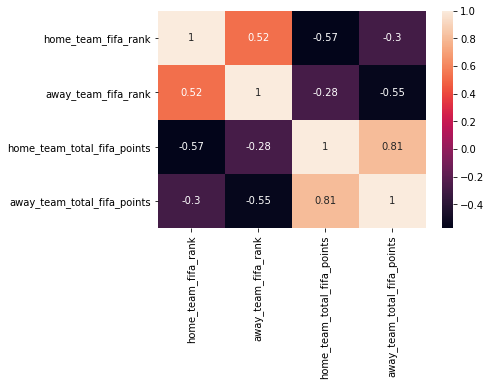

In [5]:
corr = total_x.corr() # Correlation between features
hm = sn.heatmap(data = corr, annot=True)
plt.show()

# (E) : Create Custom Dataset

In [6]:
class CustomDataset(Dataset):
    def __init__(self, X, Y, transform=None, target_transform=None):
        
        self.label = Y
        self.feature = X
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        
        feature = self.feature[idx]
        label = self.label[idx]
        
#         if self.transform:
#             feature = self.transform(feature)
            
#         if self.target_transform:
#             labels = self.target_transform(label)
            
        return feature, label

# (E) : Making Dataset Iterable

In [7]:
batch_size = 64

train_data = CustomDataset(x_train, y_train)
test_data = CustomDataset(x_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# (E) : Create Model Class

In [126]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 8),
            nn.ReLU(),
            nn.Linear(8, 3)
        )

    def forward(self, x):
        logits = self.mlp(x)
        y = F.softmax(logits, dim=1)
        return y

# (F) : Instatiate Model & Optimizer Class

In [127]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MyNet().to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.1
epochs = 100
optimizer = torch.optim.SGD(model.parameters(), learning_rate)

# (F) : Define Train & Test Loop

In [128]:
def train_loop(dataloader, model, loss_fn, optimizer, log):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        
        pred = model(X.to(torch.float32).to(device))
        loss = loss_fn(pred, y.to(device).squeeze(1))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (pred.argmax(1) == y.to(device).squeeze(1)).type(torch.float).sum().item()
               
    train_loss /= num_batches
    train_acc /= size
    
    log['train_loss'].append(train_loss)
    log['train_acc'].append(train_acc)
    
    print(f"Train Result: \n Accuracy: {(100*train_acc):>0.1f}%, Avg Train loss: {train_loss:>8f} \n")


def test_loop(dataloader, model, loss_fn, log):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(torch.float32).to(device))
            loss = loss_fn(pred, y.to(device).squeeze(1))
            
            test_loss += loss.item()
            test_acc += (pred.argmax(1) == y.to(device).squeeze(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    test_acc /= size
    
    log['test_loss'].append(test_loss)
    log['test_acc'].append(test_acc)
    
    print(f"Test Result: \n Accuracy: {(100*test_acc):>0.1f}%, Avg Test loss: {test_loss:>8f} \n")

# (F) : Training Process

In [129]:
log = {'train_loss':[], 'test_loss' : [], 'train_acc' : [], 'test_acc' : []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train()
    train_loop(train_loader, model, criterion, optimizer, log)
    model.eval()
    test_loop(test_loader, model, criterion, log)
print("Done!")

Epoch 1
-------------------------------
Train Result: 
 Accuracy: 48.4%, Avg Train loss: 1.067575 

Test Result: 
 Accuracy: 48.9%, Avg Test loss: 1.044338 

Epoch 2
-------------------------------
Train Result: 
 Accuracy: 48.4%, Avg Train loss: 1.044054 

Test Result: 
 Accuracy: 48.9%, Avg Test loss: 1.039859 

Epoch 3
-------------------------------
Train Result: 
 Accuracy: 48.4%, Avg Train loss: 1.038050 

Test Result: 
 Accuracy: 48.9%, Avg Test loss: 1.034464 

Epoch 4
-------------------------------
Train Result: 
 Accuracy: 48.4%, Avg Train loss: 1.029477 

Test Result: 
 Accuracy: 48.9%, Avg Test loss: 1.028959 

Epoch 5
-------------------------------
Train Result: 
 Accuracy: 48.4%, Avg Train loss: 1.017254 

Test Result: 
 Accuracy: 48.9%, Avg Test loss: 1.019591 

Epoch 6
-------------------------------
Train Result: 
 Accuracy: 51.0%, Avg Train loss: 1.004108 

Test Result: 
 Accuracy: 49.3%, Avg Test loss: 1.011096 

Epoch 7
-------------------------------
Train Result

Train Result: 
 Accuracy: 56.6%, Avg Train loss: 0.970452 

Test Result: 
 Accuracy: 58.1%, Avg Test loss: 0.953540 

Epoch 54
-------------------------------
Train Result: 
 Accuracy: 56.4%, Avg Train loss: 0.969404 

Test Result: 
 Accuracy: 55.4%, Avg Test loss: 0.970811 

Epoch 55
-------------------------------
Train Result: 
 Accuracy: 56.5%, Avg Train loss: 0.969486 

Test Result: 
 Accuracy: 54.2%, Avg Test loss: 0.981838 

Epoch 56
-------------------------------
Train Result: 
 Accuracy: 56.3%, Avg Train loss: 0.969780 

Test Result: 
 Accuracy: 53.4%, Avg Test loss: 0.989288 

Epoch 57
-------------------------------
Train Result: 
 Accuracy: 56.5%, Avg Train loss: 0.969952 

Test Result: 
 Accuracy: 53.6%, Avg Test loss: 0.984815 

Epoch 58
-------------------------------
Train Result: 
 Accuracy: 56.7%, Avg Train loss: 0.969730 

Test Result: 
 Accuracy: 53.6%, Avg Test loss: 0.984918 

Epoch 59
-------------------------------
Train Result: 
 Accuracy: 56.5%, Avg Train los

# (F) Report Accuracy On Test Set

In [130]:
print('The Accuracy of Test Set Is:')
model.eval()
test_loop(test_loader, model, criterion, log)

The Accuracy of Test Set Is:
Test Result: 
 Accuracy: 57.1%, Avg Test loss: 0.958217 



# (F) Change The Model For Getting Better Result

In [143]:
class NewNet(nn.Module):
    def __init__(self):
        super(NewNet, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 25),
            nn.ReLU(),
            nn.Linear(25, 8),
            nn.ReLU(),
            nn.Linear(8, 3),
        )

    def forward(self, x):
        logits = self.mlp(x)
        y = F.softmax(logits, dim=1)
        return y

# (F) : Instatiate New Model & Optimizer Class 

In [144]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model_new = NewNet().to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.20
epochs = 100
optimizer = torch.optim.SGD(model_new.parameters(), learning_rate)

# (F) : Training Process On New Model
Point1: New model 

In [145]:
log = {'train_loss':[], 'test_loss' : [], 'train_acc' : [], 'test_acc' : []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_new.train()
    train_loop(train_loader, model_new, criterion, optimizer, log)
    model_new.eval()
    test_loop(test_loader, model_new, criterion, log)
print("Done!")

Epoch 1
-------------------------------
Train Result: 
 Accuracy: 43.2%, Avg Train loss: 1.070709 

Test Result: 
 Accuracy: 48.9%, Avg Test loss: 1.045177 

Epoch 2
-------------------------------
Train Result: 
 Accuracy: 48.4%, Avg Train loss: 1.045114 

Test Result: 
 Accuracy: 48.9%, Avg Test loss: 1.038001 

Epoch 3
-------------------------------
Train Result: 
 Accuracy: 49.0%, Avg Train loss: 1.025643 

Test Result: 
 Accuracy: 51.4%, Avg Test loss: 1.001554 

Epoch 4
-------------------------------
Train Result: 
 Accuracy: 55.4%, Avg Train loss: 0.987159 

Test Result: 
 Accuracy: 54.2%, Avg Test loss: 0.976329 

Epoch 5
-------------------------------
Train Result: 
 Accuracy: 56.1%, Avg Train loss: 0.976291 

Test Result: 
 Accuracy: 61.1%, Avg Test loss: 0.941364 

Epoch 6
-------------------------------
Train Result: 
 Accuracy: 56.2%, Avg Train loss: 0.973786 

Test Result: 
 Accuracy: 59.4%, Avg Test loss: 0.948028 

Epoch 7
-------------------------------
Train Result

Train Result: 
 Accuracy: 56.7%, Avg Train loss: 0.966676 

Test Result: 
 Accuracy: 59.5%, Avg Test loss: 0.946512 

Epoch 54
-------------------------------
Train Result: 
 Accuracy: 56.3%, Avg Train loss: 0.967750 

Test Result: 
 Accuracy: 56.9%, Avg Test loss: 0.958415 

Epoch 55
-------------------------------
Train Result: 
 Accuracy: 56.7%, Avg Train loss: 0.967235 

Test Result: 
 Accuracy: 57.6%, Avg Test loss: 0.956996 

Epoch 56
-------------------------------
Train Result: 
 Accuracy: 56.6%, Avg Train loss: 0.967608 

Test Result: 
 Accuracy: 52.9%, Avg Test loss: 0.984107 

Epoch 57
-------------------------------
Train Result: 
 Accuracy: 56.6%, Avg Train loss: 0.967510 

Test Result: 
 Accuracy: 60.5%, Avg Test loss: 0.946816 

Epoch 58
-------------------------------
Train Result: 
 Accuracy: 56.6%, Avg Train loss: 0.967192 

Test Result: 
 Accuracy: 55.1%, Avg Test loss: 0.969109 

Epoch 59
-------------------------------
Train Result: 
 Accuracy: 56.6%, Avg Train los

In [111]:
log = {'train_loss':[], 'test_loss' : [], 'train_acc' : [], 'test_acc' : []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_new.train()
    train_loop(train_loader, model_new, criterion, optimizer, log)
    model_new.eval()
    test_loop(test_loader, model_new, criterion, log)
print("Done!")

Epoch 1
-------------------------------
Train Result: 
 Accuracy: 48.0%, Avg Train loss: 1.063400 

Test Result: 
 Accuracy: 48.9%, Avg Test loss: 1.043996 

Epoch 2
-------------------------------
Train Result: 
 Accuracy: 48.4%, Avg Train loss: 1.033839 

Test Result: 
 Accuracy: 48.9%, Avg Test loss: 1.023299 

Epoch 3
-------------------------------
Train Result: 
 Accuracy: 51.5%, Avg Train loss: 1.004321 

Test Result: 
 Accuracy: 55.6%, Avg Test loss: 0.975852 

Epoch 4
-------------------------------
Train Result: 
 Accuracy: 56.3%, Avg Train loss: 0.981016 

Test Result: 
 Accuracy: 58.0%, Avg Test loss: 0.958648 

Epoch 5
-------------------------------
Train Result: 
 Accuracy: 56.2%, Avg Train loss: 0.975265 

Test Result: 
 Accuracy: 55.6%, Avg Test loss: 0.969098 

Epoch 6
-------------------------------
Train Result: 
 Accuracy: 56.2%, Avg Train loss: 0.973249 

Test Result: 
 Accuracy: 54.8%, Avg Test loss: 0.975562 

Epoch 7
-------------------------------
Train Result

Test Result: 
 Accuracy: 56.4%, Avg Test loss: 0.964794 

Epoch 53
-------------------------------
Train Result: 
 Accuracy: 56.6%, Avg Train loss: 0.968981 

Test Result: 
 Accuracy: 52.7%, Avg Test loss: 1.003419 

Epoch 54
-------------------------------
Train Result: 
 Accuracy: 56.2%, Avg Train loss: 0.971044 

Test Result: 
 Accuracy: 59.6%, Avg Test loss: 0.947416 

Epoch 55
-------------------------------
Train Result: 
 Accuracy: 56.4%, Avg Train loss: 0.969668 

Test Result: 
 Accuracy: 54.3%, Avg Test loss: 0.978231 

Epoch 56
-------------------------------
Train Result: 
 Accuracy: 56.4%, Avg Train loss: 0.970671 

Test Result: 
 Accuracy: 57.8%, Avg Test loss: 0.957000 

Epoch 57
-------------------------------
Train Result: 
 Accuracy: 56.5%, Avg Train loss: 0.970243 

Test Result: 
 Accuracy: 58.8%, Avg Test loss: 0.949725 

Epoch 58
-------------------------------
Train Result: 
 Accuracy: 56.6%, Avg Train loss: 0.969934 

Test Result: 
 Accuracy: 60.4%, Avg Test loss:

# (F) Report Accuracy On Test Set On New Model
Point 1: In this new model by adding node to 25 instead of 20 we in crease accuracy by 3%.

Point 2: Increasing Accuracy is so hard .

In [146]:
print('The Accuracy of Test Set Is:')
model_new.eval()
test_loop(test_loader, model_new, criterion, log)

The Accuracy of Test Set Is:
Test Result: 
 Accuracy: 59.1%, Avg Test loss: 0.959692 



# (G) : Predict Iran Matches

In [95]:
x_1_1 = 20               # Iran Rank
x_1_2 = 1564.61          # Iran Point
x_2_1 = 5                # England Rank
x_2_2 = 1728.47          # England Point
x_3_1 = 19               # Wels Rank
x_3_2 = 1569.82          # Wels Point
x_4_1 = 16               # USA Rank
x_4_2 = 1627.48          # USA Point

## Iran VS England

In [147]:
Iran_England_Numpy = np.array([x_1_1, x_2_1, x_1_2, x_3_2])
Iran_England_Numpy_Normalized = (Iran_England_Numpy - x_test_mean)/x_test_std
Iran_England = torch.from_numpy(Iran_England_Numpy_Normalized.astype(np.float32))
Iran_England = torch.reshape(Iran_England, (1, 4))
Iran_England = Iran_England.to(device)
model_new.eval()
with torch.no_grad():
    pred = model_new(Iran_England)

print(f"Probablity of winning Iran against England: {(100 * pred[0, 2]):>0.1f}%")

Probablity of winning Iran against England: 55.3%


## Iran VS Wels

In [148]:
Iran_Wels_Numpy = np.array([x_1_1, x_3_1, x_1_2, x_3_2])
Iran_Wels_Numpy_Normalized = (Iran_Wels_Numpy - x_test_mean)/x_test_std
Iran_Wels = torch.from_numpy(Iran_Wels_Numpy_Normalized.astype(np.float32))
Iran_Wels = torch.reshape(Iran_Wels, (1, 4))
Iran_Wels = Iran_Wels.to(device)
model_new.eval()
with torch.no_grad():
    pred = model_new(Iran_Wels)

print(f"Probablity of winning Iran against Wels: {(100 * pred[0, 2]):>0.1f}%")

Probablity of winning Iran against Wels: 56.1%


## Iran VS USA

In [149]:
Iran_USA_Numpy = np.array([x_1_1, x_4_1, x_1_2, x_4_2])
Iran_USA_Numpy_Normalized = (Iran_USA_Numpy - x_test_mean)/x_test_std
Iran_USA = torch.from_numpy(Iran_USA_Numpy_Normalized.astype(np.float32))
Iran_USA = torch.reshape(Iran_USA, (1, 4))
Iran_USA = Iran_USA.to(device)
model_new.eval()
with torch.no_grad():
    pred = model_new(Iran_USA)

print(f"Probablity of winning Iran against USA: {(100 * pred[0, 2]):>0.1f}%")

Probablity of winning Iran against USA: 48.9%
